In [1]:
%config InlineBackend.figure_format='retina'
import torch
import torch.nn.functional as F
from torch.nn import Softmax, Parameter
from torch.utils.data import TensorDataset, DataLoader

import torchquantum as tq
from torchquantum.operators import op_name_dict
from typing import List

import numpy as np
from sklearn.model_selection import train_test_split

from tqdm import tqdm, trange
from IPython.display import clear_output  # for showing the plot dynamically
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from seaborn import set_palette, color_palette

set_palette('Set2')  # for better color

## Defining VQC Model

In [2]:
class TQNet(tq.QuantumModule):
    def __init__(self, layers: List[tq.QuantumModule], encoder=None):
        super().__init__()

        self.encoder = encoder
        self.layers = tq.QuantumModuleList()

        for layer in layers:
            self.layers.append(layer)

        self.service = "TorchQuantum"
        self.measure = tq.MeasureAll(tq.PauliZ)

    def forward(self, device, x):
        bsz = x.shape[0]
        device.reset_states(bsz)

        if self.encoder:
            self.encoder(device, x)

        for layer in self.layers:
            layer(device)

        meas = self.measure(device)

        return meas


class TQLayer(tq.QuantumModule):
    def __init__(self, gates: List[tq.QuantumModule]):
        super().__init__()

        self.service = "TorchQuantum"

        self.layer = tq.QuantumModuleList()
        for gate in gates:
            self.layer.append(gate)

    @tq.static_support
    def forward(self, q_device):
        for gate in self.layer:
            gate(q_device)

class TQModel(tq.QuantumModule):
    def __init__(self, net, n_wires, n_class):
        super().__init__()
        self.net = net
        self.device = tq.QuantumDevice(n_wires=n_wires).to(torch_device)
        self.bias = Parameter(torch.zeros(n_class).to(torch_device))
        self.n_class = n_class

    def forward(self, x):
        meas = self.net.forward(self.device, x)  # raw measurement result
    
        # Repeat tensor n_class times along new dimension
        meas = meas.unsqueeze(2).expand(-1, -1, self.n_class)

        # Create a mask to determine which elements to average
        mask = torch.arange(self.n_class, device=meas.device).view(1, 1, self.n_class) == torch.arange(meas.size(1), device=meas.device).view(1, -1, 1) % self.n_class

        # Apply the mask to the tensor
        masked_meas = meas * mask.float()

        # Compute the sum of each channel group and divide by the count to get the mean
        sum_meas = masked_meas.sum(dim=1)
        count_meas = mask.sum(dim=1).float()
        avg_meas = sum_meas / count_meas

        avg_meas += self.bias
        return Softmax(dim=1)(avg_meas)

    def pred(self, x):
        return torch.argmax(self.forward(x), dim=1)

    def score(self, X_test, y_test):
        pred = self.pred(X_test)
        return (pred == y_test).float().mean().item()

In [3]:
def densed_angle_encoder(n_wires, rot1='rx', rot2='rz'):
    '''
    generate the densed angle encoder list used by tq.GeneralEncoder
    '''
    enc1 = [{'input_idx':[i], 'func':rot1, 'wires':[i]}
            for i in range(n_wires)]
    enc2 = [{'input_idx':[i+n_wires], 'func':rot2, 'wires':[i]}
            for i in range(n_wires)]
    return enc1 + enc2

In [4]:
def simplified_two_design(n_wires, n_layers):
    layers = []
    for layer in range(n_layers):
        cz1 = [op_name_dict['cz'](trainable=False, has_params=False, wires=[2 * i, 2 * i + 1])
               for i in range(n_wires // 2)]
        ry1 = [op_name_dict['ry'](trainable=True, has_params=True, wires=[i]) for i in range(n_wires // 2 * 2)]
        cz2 = [op_name_dict['cz'](trainable=False, has_params=False, wires=[2 * i - 1, 2 * i]) 
               for i in range(1, (n_wires + 1)// 2)]
        ry2 = [op_name_dict['ry'](trainable=True, has_params=True, wires=[i]) 
               for i in range(1, (n_wires - 1) // 2 * 2 + 1)]
        layers += (cz1 + ry1 + cz2 + ry2)
    return layers

## Training of Predictor Model

In [5]:
n_wires = 8
n_layers = 1
n_class = 2

# torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch_device = torch.device('cpu')

encoder = tq.GeneralEncoder(densed_angle_encoder(n_wires))

first_layer = [op_name_dict['ry'](trainable=True, has_params=True, wires=[w]) 
               for w in range(n_wires)]
repeated_layer = simplified_two_design(n_wires, n_layers)

first_layer = TQLayer(first_layer)
repeated_layer = TQLayer(repeated_layer)
layers = [first_layer, repeated_layer]

In [6]:
net = TQNet(layers=layers, encoder=encoder)
model = TQModel(net, n_wires=n_wires, n_class=n_class).to(torch_device)

X, y = torch.load('gnd.pt')

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        test_size=.2, random_state=0)
X_train = X_train.to(torch_device)
X_test = X_test.to(torch_device)
y_train = y_train.to(torch_device)
y_test = y_test.to(torch_device)

dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [9]:
with torch.no_grad():
    print('train score:', model.score(X_train[:400] , y_train[:400]))
    print('test score:', model.score(X_test[:400], y_test[:400]))

train score: 1.0
test score: 1.0


In [8]:
model.load_state_dict(torch.load('gnd16_model.pt'))

<All keys matched successfully>

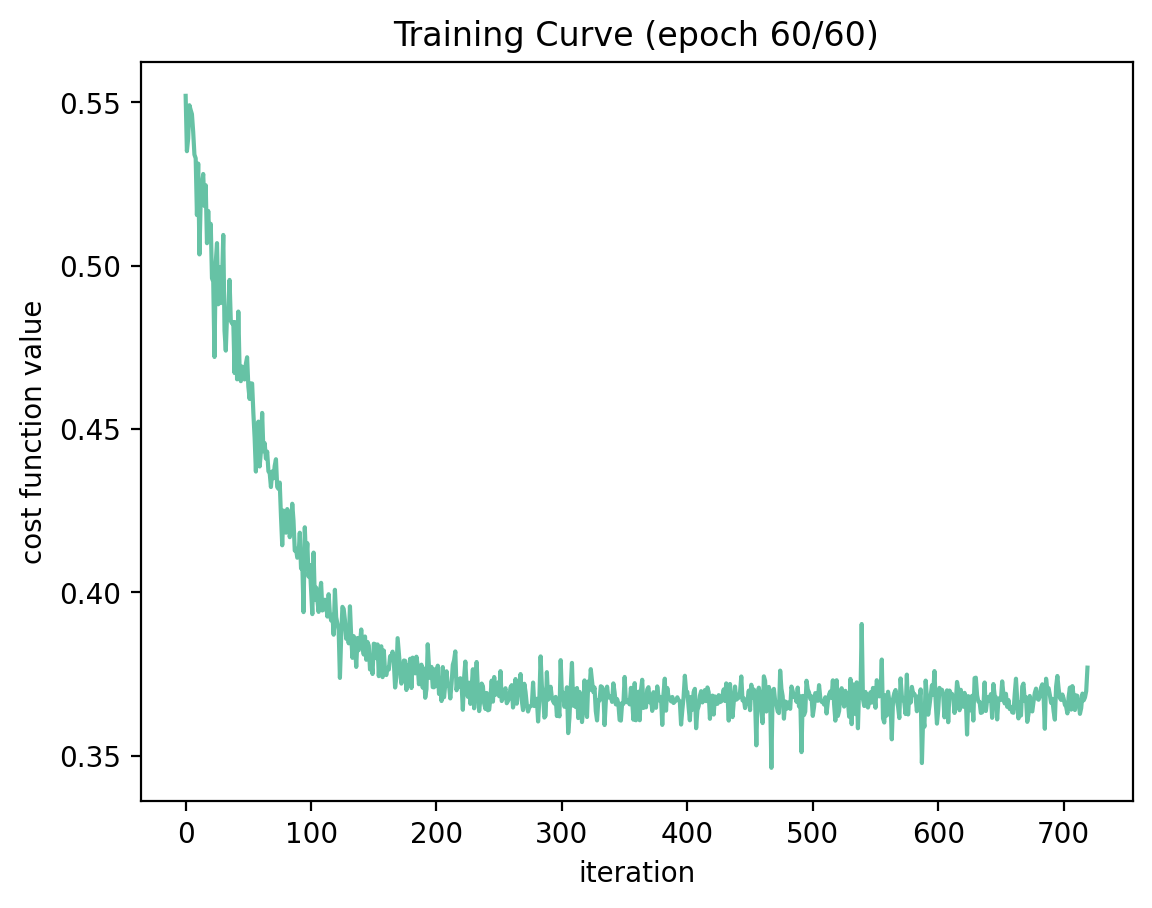

100%|███████████████████████████████████████████| 60/60 [00:33<00:00,  1.77it/s]


In [12]:
n_epochs = 60

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = torch.nn.NLLLoss()

cost_hist = []  # collect history data
for epoch in trange(n_epochs):
    for x_batch, y_batch in dataloader:
        pred = model(x_batch)
        loss = loss_fn(pred.log(), y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        
        cost_hist.append(loss.item())
        
    # dynamic plot of the training curve
    clear_output(wait=True)
    plt.title(f'Training Curve (epoch {epoch+1}/{n_epochs})')
    plt.xlabel('iteration')
    plt.ylabel('cost function value')
    plt.plot(cost_hist)
    plt.show()

In [23]:
with torch.no_grad():
    print('train score:', model.score(X_train[:400], y_train[:400]))
    print('test score:', model.score(X_test[:400], y_test[:400]))
# torch.save(model.state_dict(), './gnd16_model.pt')

train score: 1.0
test score: 1.0


## Feature Attribution

In [12]:
for p in model.parameters():
    p.requires_grad_(False)

In [13]:
from FeatureAttr import *

In [14]:
def plot_explanation(x, x0=None):
    
    with torch.no_grad():
        pred = model.pred(x)
    x_ig = integrated_grad(x_test=x, model=model, x0=x0)
    x_grad = vanilla_grad(x_test=x, model=model)
    x_ip = grad_x_input(x_test=x, model=model, vanilla=x_grad)
    # x_sg = smooth_grad(x_test=x, model=model, method=vanilla_grad, noise=.2, n=30)
    
    x_ig, x_grad, x_ip = x_ig.cpu(), x_grad.cpu(), x_ip.cpu()
    x = x.detach().cpu()
    
    fig, ax = plt.subplots(len(x), 4, figsize=(7. / 5 * 4, 1.5 * len(x)))
    fig_width = torch.sqrt(torch.tensor(x[0].flatten().shape)).int().item()
    
    for r, ax_row in enumerate(ax):
        ax_row[0].imshow(x[r].reshape(fig_width, -1), cmap='gray')
        ax_row[0].set_title(f'pred: {pred[r]}')
        ax_row[0].set_ylabel(r)

        vmin = min([torch.min(x_grad[r]), torch.min(x_ip[r]), torch.min(x_ig[r])])
        vmax = max([torch.max(x_grad[r]), torch.max(x_ip[r]), torch.max(x_ig[r])])
        vmax = max(abs(vmin), abs(vmax))
        vmin = -vmax
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        
        im1 = centered_attribution_plot(ax_row[1], x_grad[r], norm=norm)
        im2 = centered_attribution_plot(ax_row[2], x_ip[r], norm=norm)
        im3 = centered_attribution_plot(ax_row[3], x_ig[r], norm=norm)
        # im4 = centered_attribution_plot(ax_row[4], x_sg[r], norm=norm)
        
        ax_row[1].set_title('saliency')
        ax_row[2].set_title(r'G$\odot$I')
        ax_row[3].set_title('IG')
        # ax_row[4].set_title('Smooth')

        fig.colorbar(im1, ax=ax_row, fraction=0.046, pad=0.04)
        
    # plt.tight_layout()
    
    del x_ig, x_grad, x_ip
    torch.cuda.empty_cache()

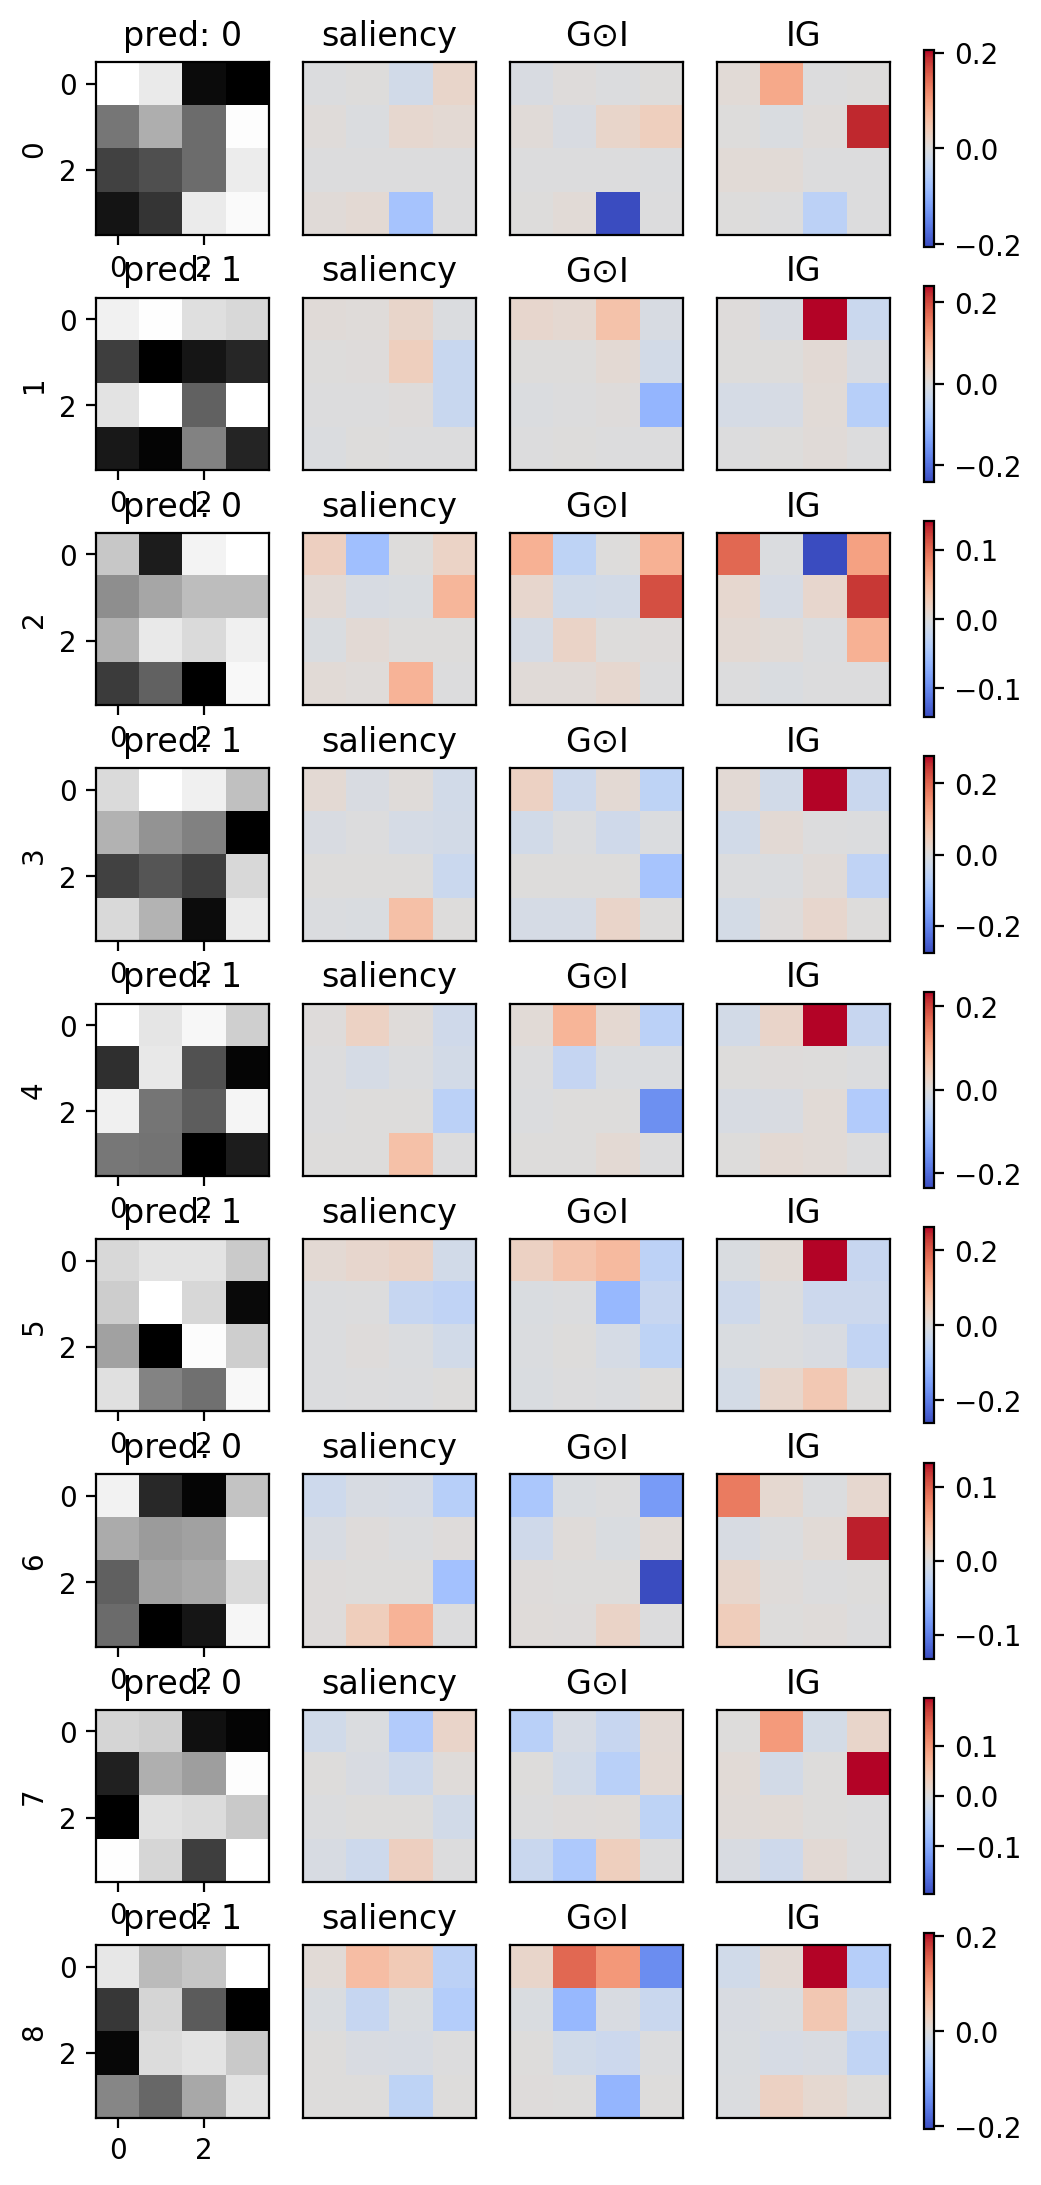

In [15]:
plot_explanation(X_test[1:10])

In [27]:
result_saliency = []
result_GxI = []
result_IG = []
result_SG = []

# result_saliency, result_GxI, result_IG = np.load(
#     'saved_models/sens-n_2layer_2022-12-25T23:45:13.npy')
with torch.no_grad():
    sample_instances = X_test[torch.randperm(len(X_test))[:50]]
    
for s in tqdm(sample_instances):
    attr_saliency = vanilla_grad(s, model)
    attr_GxI = grad_x_input(s, model, vanilla=attr_saliency)
    attr_IG = integrated_grad(s, model)
    attr_SG = smooth_grad(s, model, method=vanilla_grad, noise=.2, n=30)
    rs, rg, ri, rsg = sensitivity_n(model, int(16 * 0.8), 
                               [attr_saliency, attr_GxI, attr_IG, attr_SG], s)
    # rs, rg, ri = sensitivity_n(model, int(30 * 0.8), [attr_saliency, attr_GxI, attr_IG], s)
    result_saliency.append(rs)
    result_GxI.append(rg)
    result_IG.append(ri)
    result_SG.append(rsg)

100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.82it/s]


In [71]:
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)
        
def plot_sensitivity_n(*results, labels):
    
    assert len(results) == len(labels)
    
    fig, ax = plt.subplots(figsize=(5, 3.5))
    for r, l in zip(results, labels):
        r = np.array(r)
        ax.plot(range(1, len(r.mean(0)) + 1), r.mean(0), label=l)
        ax.fill_between(range(1, len(r.mean(0)) + 1), r.mean(0) - r.std(0) / 2, r.mean(0) + r.std(0) / 2, alpha=.2)
    ax.set_xlabel('feature subset size')
    ax.set_ylabel('correlation')
    ax.legend()
    
    fig = tikzplotlib_fix_ncols(fig)

In [70]:
import tikzplotlib

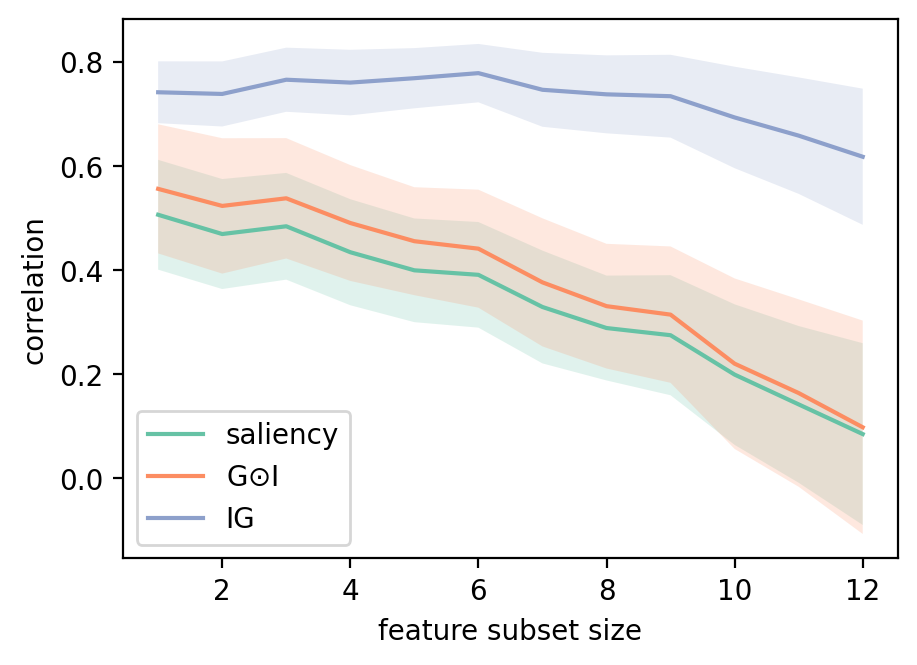

In [72]:
labels = ['saliency', r'G$\odot$I', 'IG']
plot_sensitivity_n(result_saliency, result_GxI, result_IG, labels=labels)
tikzplotlib.save('gnd16_sens_n.tex')

In [31]:
with torch.no_grad():
    sample_instances = X_test[torch.randperm(len(X_test))[:50]]
    
bar_list = []
# bar_list = np.load('saved_models/sens-max_2layer_2022-12-25T23:45:20.npy')

for method in [vanilla_grad, grad_x_input, integrated_grad]:
    sens_list = []
    for instance in tqdm(sample_instances):
        sens_list.append(sensmax_monte_carlo(model, method, instance, 0.1, n=30))
    bar_list.append(sens_list)

100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  7.25it/s]


In [35]:
import tikzplotlib

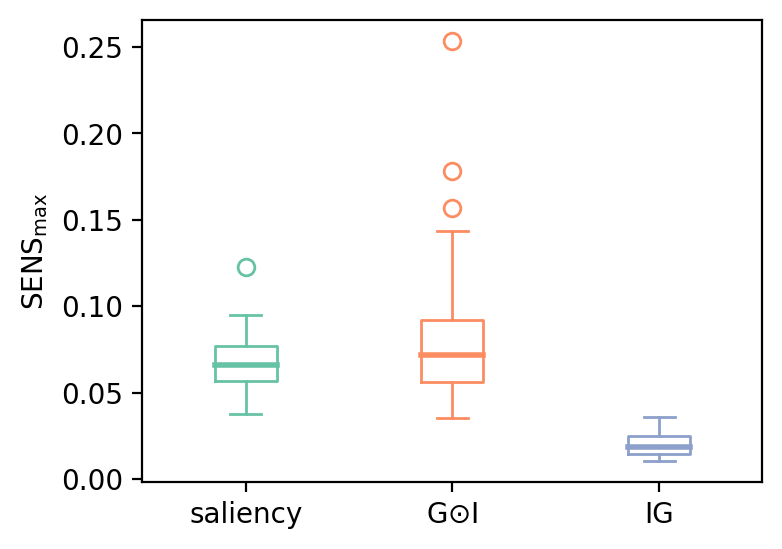

In [73]:
fig, ax = plt.subplots(figsize=(4, 3))
colors = color_palette('Set2')  # get colors from the palette

box_plot = ax.boxplot(bar_list, labels=['saliency', r'G$\odot$I', 'IG'])
ax.set_ylabel(r'SENS$_\mathrm{max}$')

# Iterate through each boxplot and customize the colors
for i, box in enumerate(box_plot['boxes']):
    # Set the color of the box
    box.set_color(colors[i])

for i, whisker in enumerate(box_plot['whiskers']):
    # Set the color of the whiskers
    whisker.set_color(colors[i // 2])

for i, cap in enumerate(box_plot['caps']):
    # Set the color of the caps
    cap.set_color(colors[i // 2])

for i, median in enumerate(box_plot['medians']):
    # Set the color of the medians
    median.set_color(colors[i])
    median.set_linewidth(2)

for i, flier in enumerate(box_plot['fliers']):
    # Set the color of the fliers
    flier.set_markeredgecolor(colors[i])

tikzplotlib.save('box.tex')